In [2]:
import pandas as pd
import numpy as np
import ta
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def create_sequence(dataset, sequence_length=50):
    """
    Create sequences from the dataset for time series analysis.
    """
    data = dataset.values if isinstance(dataset, pd.DataFrame) else dataset
    
    X = []  # sequences
    y = []  # target (next day's price)
    
    for i in range(len(data) - sequence_length):
        sequence = data[i:(i + sequence_length)]
        target = data[i + sequence_length, 3]  # Using Close price as target
        
        X.append(sequence)
        y.append(target)
    
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

def build_lstm_model(sequence_length, n_features):
    """
    Build LSTM model for price prediction
    """
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(sequence_length, n_features)),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    return model

def evaluate_predictions(y_true, y_pred):
    """
    Calculate various accuracy metrics including prediction accuracy within thresholds
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Calculate accuracy within different thresholds
    diff_percentage = np.abs((y_true - y_pred) / y_true) * 100
    accuracy_1_percent = np.mean(diff_percentage <= 1.0) * 100  # Within 1%
    accuracy_2_percent = np.mean(diff_percentage <= 2.0) * 100  # Within 2%
    accuracy_5_percent = np.mean(diff_percentage <= 5.0) * 100  # Within 5%
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'R-squared': r2,
        'MAPE': mape,
        'Accuracy_1%': accuracy_1_percent,
        'Accuracy_2%': accuracy_2_percent,
        'Accuracy_5%': accuracy_5_percent
    }

def main():
    # Load and prepare data
    gstock_data = pd.read_csv('GOOGL.csv')
    gstock_data['Date'] = pd.to_datetime(gstock_data['Date'])
    
    # Split data into train (before 2020) and test (2020 onwards)
    train_data = gstock_data[gstock_data['Date'] < '2020-01-01'].copy()
    test_data = gstock_data[gstock_data['Date'] >= '2020-01-01'].copy()
    
    features = ['Open', 'High', 'Low', 'Close']
    
    # Scale the features
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data[features])
    test_scaled = scaler.transform(test_data[features])
    
    # Create sequences
    X_train, y_train = create_sequence(train_scaled)
    X_test, y_test = create_sequence(test_scaled)
    
    # Build and train model
    sequence_length = 50
    n_features = len(features)
    model = build_lstm_model(sequence_length, n_features)
    
    print("Training the model...")
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)
    
    # Make predictions
    y_pred_scaled = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    y_pred = np.zeros((len(y_pred_scaled), len(features)))
    y_pred[:, 3] = y_pred_scaled.flatten()
    y_pred = scaler.inverse_transform(y_pred)[:, 3]
    
    y_true = np.zeros((len(y_test), len(features)))
    y_true[:, 3] = y_test
    y_true = scaler.inverse_transform(y_true)[:, 3]
    


    
    # Create DataFrame with dates and predictions
    prediction_dates = test_data['Date'][sequence_length:].reset_index(drop=True)
    predictions_df = pd.DataFrame({
        'Date': prediction_dates,
        'Actual_Price': y_true,
        'Predicted_Price': y_pred,
        'Difference': y_pred - y_true,
        'Difference_Percentage': ((y_pred - y_true) / y_true) * 100
    })

    # Calculate and print metrics
    metrics = evaluate_predictions(y_true, y_pred)
    
    print("\nModel Performance Metrics:")
    print("=========================")
    print(f"Root Mean Square Error (RMSE): ${metrics['RMSE']:.2f}")
    print(f"Mean Absolute Error (MAE): ${metrics['MAE']:.2f}")
    print(f"R-squared Score: {metrics['R-squared']:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {metrics['MAPE']:.2fprecit}%")
    print("\nPrediction Accuracy:")
    print(f"Within 1% of actual price: {metrics['Accuracy_1%']:.2f}%")
    print(f"Within 2% of actual price: {metrics['Accuracy_2%']:.2f}%")
    print(f"Within 5% of actual price: {metrics['Accuracy_5%']:.2f}%")

        
    # Display predictions
    print("\nPredicted vs Actual Prices:")
    print("===========================")
    pd.set_option('display.float_format', lambda x: '${:.2f}'.format(x) if isinstance(x, (float, int)) else str(x))
    print(predictions_df.to_string(index=False))
    
    # Save predictions to CSV
    predictions_df.to_csv('price_predictions.csv', index=False)
    print("\nPredictions have been saved to 'price_predictions.csv'")
    
    # Prepare last sequence for future predictions
    last_sequence = test_scaled[-sequence_length:]
    future_predictions = predict_next_n_days(model, last_sequence, scaler, n_days=7)
    
    # Generate dates for future predictions
    last_date = test_data['Date'].iloc[-1]
    future_dates = [(last_date + timedelta(days=i+1)).strftime('%Y-%m-%d') 
                    for i in range(7)]
    
    print("\nFuture Price Predictions:")
    print("========================")
    future_df = pd.DataFrame({
        'Date': future_dates,
        'Predicted_Price': future_predictions
    })
    print(future_df.to_string(index=False))
    
    
    # Plot results
    plt.figure(figsize=(15, 7))
    plt.plot(prediction_dates, y_true, label='Actual Prices')
    plt.plot(prediction_dates, y_pred, 'r--', label='Predicted Prices')
    
    plt.title('GOOGL Stock Price - Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

Training the model...
Epoch 1/50


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0204 - val_loss: 6.6003e-04
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0012 - val_loss: 5.9161e-04
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 9.2899e-04 - val_loss: 7.8041e-04
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 8.1595e-04 - val_loss: 6.0150e-04
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 9.3193e-04 - val_loss: 0.0011
Epoch 9/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 8.9087e-04 - val_loss: 0.0020
Epoch 10/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 8.3270e-04 - val_loss: 7.7139e-04
Epoch 11/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 7.1236e-04 - val_loss: 0.0012
Epoch 12

NameError: name 'predict_next_n_days' is not defined

Training the model...
Epoch 1/50


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0105 - val_loss: 0.0035
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 9.3423e-04 - val_loss: 0.0020
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 7.2727e-04 - val_loss: 0.0029
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 7.6561e-04 - val_loss: 0.0021
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 5.6534e-04 - val_loss: 0.0016
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 6.2827e-04 - val_loss: 0.0019
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 5.6777e-04 - val_loss: 0.0016
Epoch 9/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 5.7209e-04 - val_loss: 0.0027
Epoch 10/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 5.4270e-04 - val_loss: 9.7952e-04
Epoch 11/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 4.9670e-04 - val_loss: 0.0015
Epoch 12/50


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9960\3858189038.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_sequence[-1, 3] = next_day  # Update Close price


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

Future Price Predictions:
      Date  Predicted_Price
2022-03-25         $2282.52
2022-03-26         $2260.20
2022-03-27         $2237.82
2022-03-28         $2215.42
2022-03-29         $2196.51
2022-03-30         $2184.44
2022-03-31         $2174.62


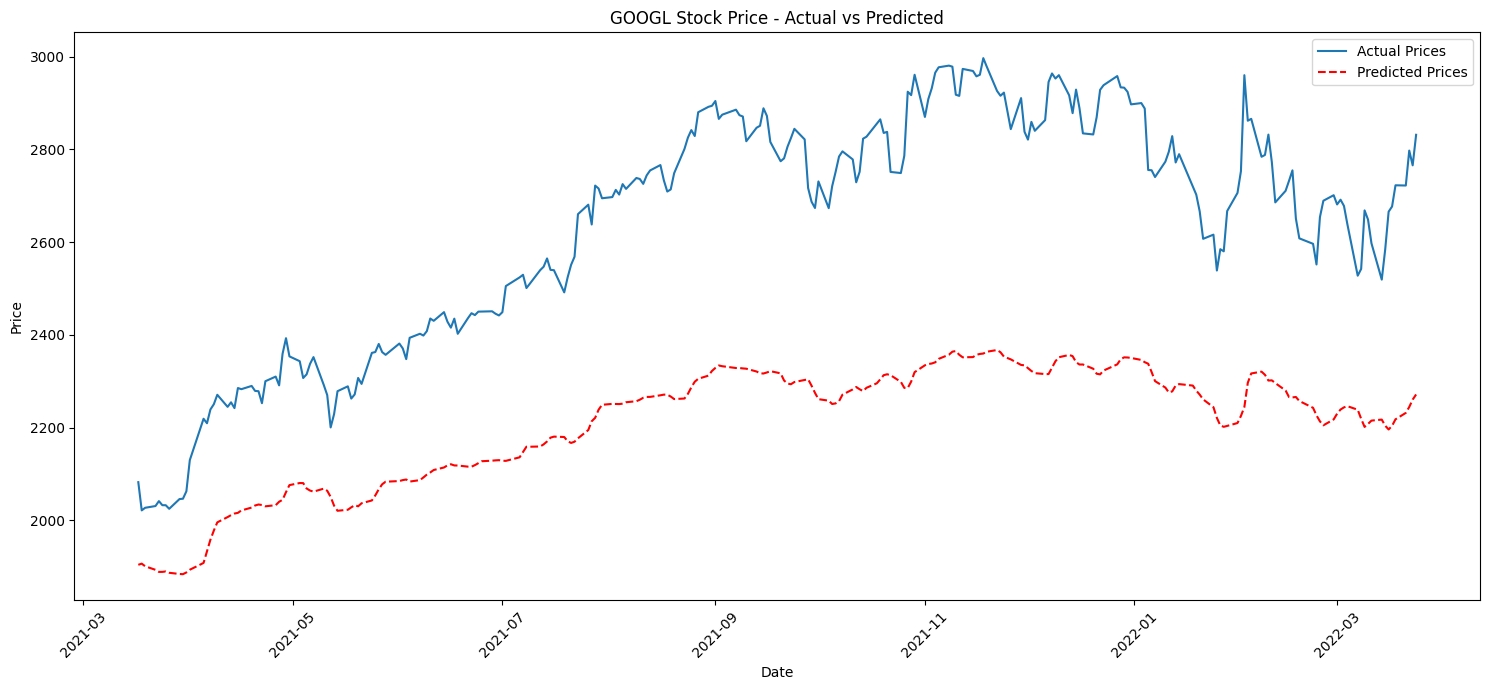

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def create_sequence(dataset, sequence_length=50):
    """
    Create sequences from the dataset for time series analysis.
    """
    data = dataset.values if isinstance(dataset, pd.DataFrame) else dataset
    
    X = []  # sequences
    y = []  # target (next day's price)
    
    for i in range(len(data) - sequence_length):
        sequence = data[i:(i + sequence_length)]
        target = data[i + sequence_length, 3]  # Using Close price as target
        
        X.append(sequence)
        y.append(target)
    
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

def build_lstm_model(sequence_length, n_features):
    """
    Build LSTM model for price prediction
    """
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(sequence_length, n_features)),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    return model

def evaluate_predictions(y_true, y_pred):
    """
    Calculate various accuracy metrics including prediction accuracy within thresholds
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Calculate accuracy within different thresholds
    diff_percentage = np.abs((y_true - y_pred) / y_true) * 100
    accuracy_1_percent = np.mean(diff_percentage <= 1.0) * 100  # Within 1%
    accuracy_2_percent = np.mean(diff_percentage <= 2.0) * 100  # Within 2%
    accuracy_5_percent = np.mean(diff_percentage <= 5.0) * 100  # Within 5%
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'R-squared': r2,
        'MAPE': mape,
        'Accuracy_1%': accuracy_1_percent,
        'Accuracy_2%': accuracy_2_percent,
        'Accuracy_5%': accuracy_5_percent
    }

def main():
    # Load and prepare data
    gstock_data = pd.read_csv('GOOGL.csv')
    gstock_data['Date'] = pd.to_datetime(gstock_data['Date'])
    
    # Split data into train (before 2020) and test (2020 onwards)
    train_data = gstock_data[gstock_data['Date'] < '2021-01-01'].copy()
    test_data = gstock_data[gstock_data['Date'] >= '2021-01-01'].copy()
    
    features = ['Open', 'High', 'Low', 'Close']
    
    # Scale the features
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data[features])
    test_scaled = scaler.transform(test_data[features])
    
    # Create sequences
    X_train, y_train = create_sequence(train_scaled)
    X_test, y_test = create_sequence(test_scaled)
    
    # Build and train model
    sequence_length = 50
    n_features = len(features)
    model = build_lstm_model(sequence_length, n_features)
    
    print("Training the model...")
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)
    
    # Make predictions
    y_pred_scaled = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    y_pred = np.zeros((len(y_pred_scaled), len(features)))
    y_pred[:, 3] = y_pred_scaled.flatten()
    y_pred = scaler.inverse_transform(y_pred)[:, 3]
    
    y_true = np.zeros((len(y_test), len(features)))
    y_true[:, 3] = y_test
    y_true = scaler.inverse_transform(y_true)[:, 3]
    


    
    # Create DataFrame with dates and predictions
    prediction_dates = test_data['Date'][sequence_length:].reset_index(drop=True)
    predictions_df = pd.DataFrame({
        'Date': prediction_dates,
        'Actual_Price': y_true,
        'Predicted_Price': y_pred,
        'Difference': y_pred - y_true,
        'Difference_Percentage': ((y_pred - y_true) / y_true) * 100
    })

    # Calculate and print metrics
    metrics = evaluate_predictions(y_true, y_pred)
    
    print("\nModel Performance Metrics:")
    print("=========================")
    print(f"Root Mean Square Error (RMSE): ${metrics['RMSE']:.2f}")
    print(f"Mean Absolute Error (MAE): ${metrics['MAE']:.2f}")
    print(f"R-squared Score: {metrics['R-squared']:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {metrics['MAPE']:.2f}%")
    print("\nPrediction Accuracy:")
    print(f"Within 1% of actual price: {metrics['Accuracy_1%']:.2f}%")
    print(f"Within 2% of actual price: {metrics['Accuracy_2%']:.2f}%")
    print(f"Within 5% of actual price: {metrics['Accuracy_5%']:.2f}%")

        
    # Display predictions
    print("\nPredicted vs Actual Prices:")
    print("===========================")
    pd.set_option('display.float_format', lambda x: '${:.2f}'.format(x) if isinstance(x, (float, int)) else str(x))
    print(predictions_df.to_string(index=False))
    
    # Save predictions to CSV
    predictions_df.to_csv('price_predictions-1year.csv', index=False)
    print("\nPredictions have been saved to 'price_predictions.csv'")
    
    # Prepare last sequence for future predictions
    last_sequence = test_scaled[-sequence_length:]
    future_predictions = predict_next_n_days(model, last_sequence, scaler, n_days=7)
    
    # Generate dates for future predictions
    last_date = test_data['Date'].iloc[-1]
    future_dates = [(last_date + timedelta(days=i+1)).strftime('%Y-%m-%d') 
                    for i in range(7)]
    
    print("\nFuture Price Predictions:")
    print("========================")
    future_df = pd.DataFrame({
        'Date': future_dates,
        'Predicted_Price': future_predictions
    })
    print(future_df.to_string(index=False))
    
    
    # Plot results
    plt.figure(figsize=(15, 7))
    plt.plot(prediction_dates, y_true, label='Actual Prices')
    plt.plot(prediction_dates, y_pred, 'r--', label='Predicted Prices')
    
    plt.title('GOOGL Stock Price - Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()